In [34]:
import os, shutil, pathlib, pickle
import matplotlib.pyplot as plt

original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cats_vs_dogs_small')

In [5]:
def make_subset(subset_name, start_ind, end_ind):
    # subset_name can be train, val or test
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)

        fnames = [f'{category}.{i}.jpg' for i in range(start_ind, end_ind)]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname, dst=dir/fname)

make_subset('train', 0, 1000)
make_subset('validation', 1000, 1500)
make_subset('test', 1500, 2500)

### Load dataset

In [ ]:
from keras.utils import image_dataset_from_directory

In [ ]:
# load train, test splits as TF datasets (batched iterators)
train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(180, 180),  # keras will do the cropping
    batch_size=32)
val_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# inspect shapes
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


2024-05-05 17:34:37.059121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-05-05 17:34:37.059333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-05-05 17:34:37.066979: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### Build model (without augmentation, without regularization)

In [6]:
import keras
from keras import layers

In [8]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)  # divide each pixel by 255 to fit in range [0,1]
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

# compile model with BCE loss
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)
# fit model
history_scratch = model.fit(
    train_dataset, epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30


63/63 [==============================] - 19s 292ms/step - loss: 0.7235 - accuracy: 0.5425 - val_loss: 0.6446 - val_accuracy: 0.6560
Epoch 2/30
63/63 [==============================] - 19s 303ms/step - loss: 0.6894 - accuracy: 0.5985 - val_loss: 0.6505 - val_accuracy: 0.6070
Epoch 3/30
63/63 [==============================] - 20s 317ms/step - loss: 0.6047 - accuracy: 0.6710 - val_loss: 0.6369 - val_accuracy: 0.6340
Epoch 4/30
63/63 [==============================] - 19s 303ms/step - loss: 0.5885 - accuracy: 0.7030 - val_loss: 0.6039 - val_accuracy: 0.6800
Epoch 5/30
63/63 [==============================] - 19s 298ms/step - loss: 0.5323 - accuracy: 0.7350 - val_loss: 0.6253 - val_accuracy: 0.6740
Epoch 6/30
63/63 [==============================] - 19s 296ms/step - loss: 0.4600 - accuracy: 0.7850 - val_loss: 0.6339 - val_accuracy: 0.6870
Epoch 7/30
63/63 [==============================] - 19s 295ms/step - loss: 0.4065 - accuracy: 0.8065 - val_loss: 0.9136 - val_accuracy: 0.6750
Epoch 8/30

In [31]:
experiments_dir = pathlib.Path('experiments')
with open(experiments_dir / 'cats_v_dogs_convnet_from_scratch.hist', 'wb') as wh:
    pickle.dump(history_scratch.history, wh)

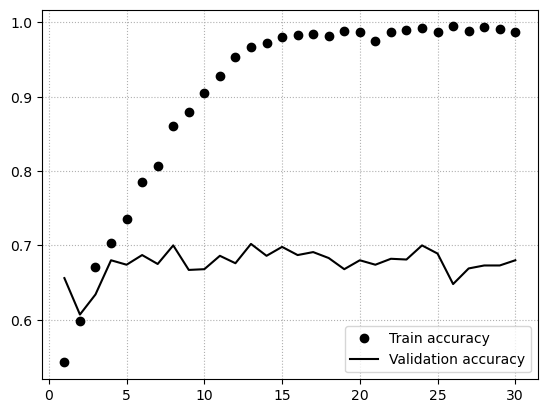

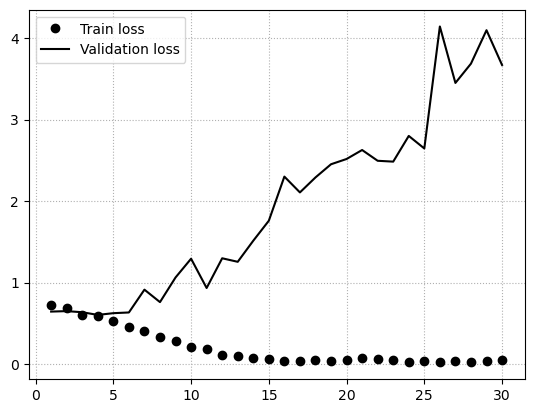

<Figure size 640x480 with 0 Axes>

In [40]:
# visualize train and val loss
history = history_scratch.history
train_accuracy = history["accuracy"]
val_accuracy = history["val_accuracy"]
epochs = range(1, len(train_accuracy)+1)

plt.plot(epochs, train_accuracy, 'ko', label='Train accuracy')
plt.plot(epochs, val_accuracy, 'k', label='Validation accuracy')
plt.grid(ls=':'); plt.legend(); plt.figure()

plt.plot(epochs, history['loss'], 'ko', label='Train loss')
plt.plot(epochs, history['val_loss'], 'k', label='Validation loss')
plt.grid(ls=':'); plt.legend(); plt.figure()

plt.show()

In [41]:
# load best version (based on validation loss) for evaluation on the test set
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

 1/63 [..............................] - ETA: 12s - loss: 0.7377 - accuracy: 0.5938

2024-05-05 21:29:18.929842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2024-05-05 21:29:18.930034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - 5s 77ms/step - loss: 0.6063 - accuracy: 0.6915
Test accuracy: 0.692


**Observation.** Train accuracy plateaus after ~15 epochs and validation accuracy basically after ~5 epochs. Train loss starts to increase quite a bit after 10 epochs and validation loss stop improving at this point. This suggests that we are overfitting the dataset despite train accuracy being near perfect. Test accuracy at 69.2% is also bad which shows the overfitting.

###